In [ ]:
# scVI with py

In [1]:
import scanpy as sc
import scvi
import seaborn as sns
# import torch
import pandas as pd
import numpy as np
import pymde
import scib
from scib_metrics.benchmark import Benchmarker
scvi.settings.seed = 0

/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRDataset from `anndata.experimen

In [2]:
print("Last run with scvi-tools version:", scvi.__version__)

Last run with scvi-tools version: 1.2.0


In [3]:
# adata1 = scanpy.read_h5ad("stage16_sample1.h5ad")
# adata2 = scanpy.read_h5ad("stage16_sample2.h5ad")
# adata3 = scanpy.read_h5ad("stage16_sample3.h5ad")

# # List of datasets:
# adatas = [ adata1, adata2, adata3 ]

adata = sc.read_h5ad("chicken_scVI2.h5ad")

/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:212: OldFormatWarning: Element '/obs/orig.ident' was written without encoding metadata.
  return func(*args, **kwargs)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:212: OldFormatWarning: Element '/obs/nCount_RNA' was written without encoding metadata.
  return func(*args, **kwargs)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:212: OldFormatWarning: Element '/obs/nFeature_RNA' was written without encoding metadata.
  return func(*args, **kwargs)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:212: OldFormatWarning: Element '/obs/species' was written without encoding metadata.
  return func(*args, **kwargs)
/home/suresh/miniforge3/lib/python3.10/site-packages/anndata/_io/utils.py:212: OldFormatWarning: Element '/obs/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/suresh/miniforge3/lib/python3.10/

In [4]:
adata.layers['counts']=adata.raw.X.copy() 

In [5]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="dataset",
    subset=True,
)

In [6]:
adata

AnnData object with n_obs × n_vars = 50547 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'dataset', 'consensus_type', 'integrated_snn_res.1', 'seurat_clusters'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="dataset")

In [7]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [8]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/suresh/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 158/158: 100%|█| 158/158 [13:34<00:00,  5.07s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=158` reached.


Epoch 158/158: 100%|█| 158/158 [13:34<00:00,  5.15s/it, v_num=1, train_loss_step


In [10]:
# use scANVI now
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="consensus_type",
    unlabeled_category="Unknown",
)

In [11]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/suresh/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [03:50<00:00, 11.34s/it, v_num=1, train_loss_step=622

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [03:50<00:00, 11.52s/it, v_num=1, train_loss_step=622


In [17]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [18]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(adata)

/tmp/ipykernel_435811/4149704689.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [13]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY], accelerator="cpu")

INFO     Using cpu for `pymde.preserve_neighbors`.                                                                 


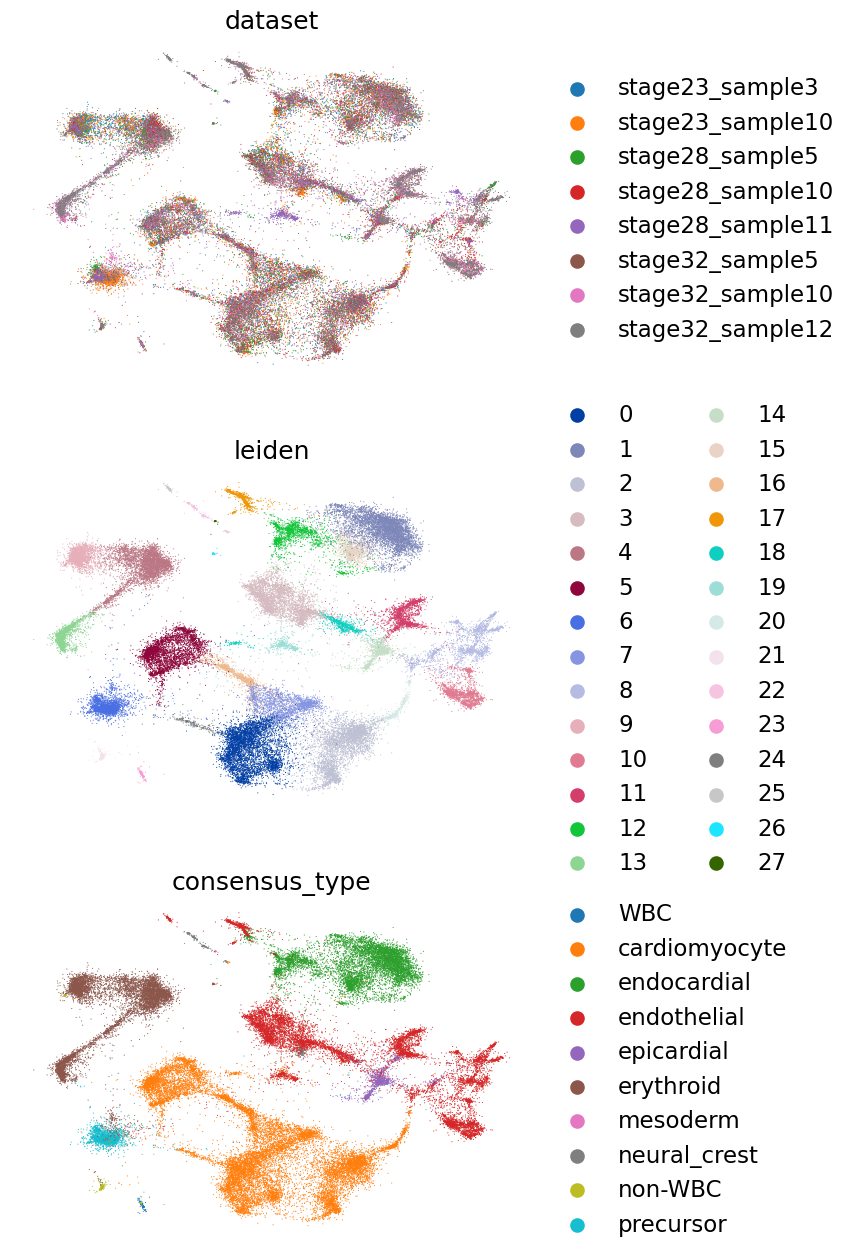

In [19]:
sc.pl.embedding(
    adata,
    basis=SCANVI_MDE_KEY,
    color=["dataset", "leiden","consensus_type"],
    frameon=False,
    ncols=1,
)

In [15]:
# save?
adata.write('chicken_scANVI_new2.h5ad')

In [2]:
# read file
adata = sc.read_h5ad("chicken_scANVI_new2.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 50547 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'species', 'dataset', 'consensus_type', 'integrated_snn_res.1', 'seurat_clusters', '_scvi_batch', '_scvi_labels'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'consensus_type_colors', 'hvg'
    obsm: 'X_scANVI', 'X_scANVI_MDE'
    layers: 'counts'

In [5]:
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.leiden(adata)

/tmp/ipykernel_831771/1418598917.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [6]:
sc.tl.umap(adata)

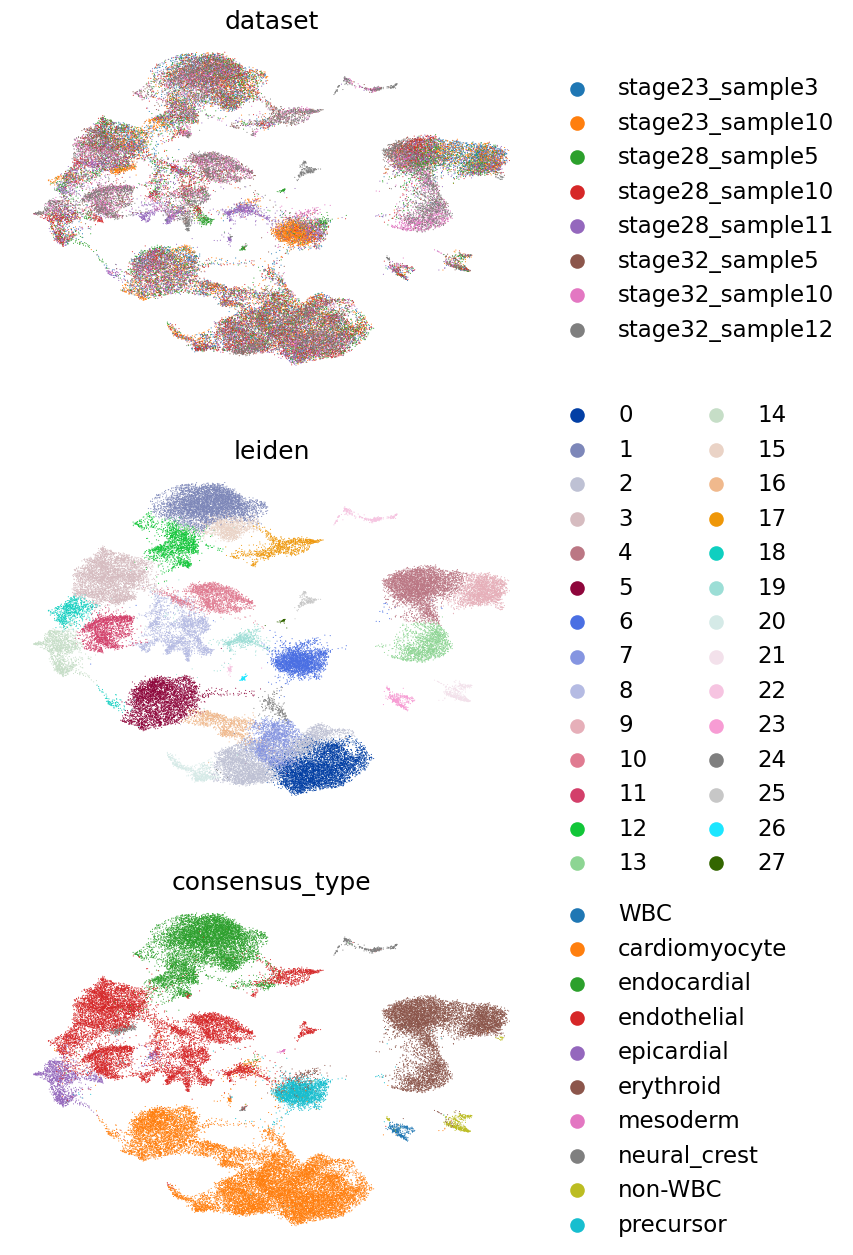

In [7]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["dataset", "leiden","consensus_type"],
    frameon=False,
    ncols=1,
)

In [8]:
pd.DataFrame(adata.obs['leiden']).to_csv('chicken_scANVI_clusters.csv')